# Outline

[Part 1: Load Data](#Part-1:-Load-Data)
[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
[Part 3: TF-IDF](#Part-3:-TF-IDF)
[Part 4: K-means clustering](#Part-4:-K-means-clustering)
[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)

# Part 1:Load Data

In [13]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
# REGULAR EXPRESSION
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/adam/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/adam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [3]:
#import three lists: titles and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", or "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root.

In [14]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 179 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [15]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    # exclude stop words and tokenize the document, generate a list of string 
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# tokenization without stemming
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [34]:
# testing tokenization and stemming
tokenization_and_stemming("the only reason why i am so into techno music is i found inner peace when i danced to it")

['reason', 'techno', 'music', 'found', 'inner', 'peac', 'danc']

In [35]:
# testing tokenization
tokenization('the only reason why i am so into techno music is i found inner peace when i danced to it')

['reason', 'techno', 'music', 'found', 'inner', 'peace', 'danced']

In [36]:
# 1. do tokenization and stemming for all the documents
# 2. also just do tokenization for all the documents
# the goal is to create a mapping from stemmed words to original tokenized words for result interpretation.
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [57]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print (vocab_frame_dict['look'])

looking


# Part 3. TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [66]:
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=2000,
                                 min_df=0, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,3))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 2000 terms.


In [67]:
# check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 2000,
 'min_df': 0,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

In [69]:
# words
tf_selected_words = tfidf_model.get_feature_names()

In [70]:
# print out words
tf_selected_words

["'d",
 "'m",
 "'s apart",
 "'s bodi",
 "'s car",
 "'s death",
 "'s father",
 "'s friend",
 "'s home",
 "'s hous",
 "'s life",
 "'s marriag",
 "'s men",
 "'s mother",
 "'s murder",
 "'s offic",
 "'s plan",
 "'s son",
 "'s voic",
 "'s wife",
 'abandon',
 'abil',
 'abl',
 'aboard',
 'abus',
 'accept',
 'accid',
 'accident',
 'accompani',
 'accomplic',
 'accus',
 'acquaint',
 'act',
 'action',
 'actor',
 'actual',
 'adam',
 'address',
 'admir',
 'admit',
 'adrian',
 'advanc',
 'advantag',
 'adventur',
 'advis',
 'affair',
 'africa',
 'african',
 'african queen',
 'afterward',
 'age',
 'agent',
 'ago',
 'agre',
 'aid',
 'aim',
 'air',
 'aircraft',
 'airport',
 'al',
 'albert',
 'alcohol',
 'alderaan',
 'alex',
 'alexand',
 'ali',
 'alic',
 'alien',
 'aliv',
 'allenbi',
 'allnut',
 'allow',
 'alon',
 'alreadi',
 'altern',
 'alvi',
 'alway',
 'ambush',
 'america',
 'american',
 'ami',
 'andi',
 "andi 's",
 'andrew',
 'angel',
 'angela',
 'anger',
 'angri',
 'angrili',
 'anim',
 'anita',
 'an

In [99]:
# tf-idf matrix
print(tfidf_matrix)

  (0, 1977)	0.005186070480495331
  (0, 688)	0.0048831004062112465
  (0, 1172)	0.005835388719067226
  (0, 1989)	0.023341554876268905
  (0, 660)	0.005079514961451707
  (0, 3)	0.005079514961451707
  (0, 9)	0.004622554227410152
  (0, 11)	0.006175275129691232
  (0, 1336)	0.006371689684931691
  (0, 1966)	0.0047054218284321506
  (0, 10)	0.00541940137207571
  (0, 279)	0.003839856783051257
  (0, 673)	0.013867662682230457
  (0, 1924)	0.005079514961451707
  (0, 1976)	0.004622554227410152
  (0, 19)	0.004978722087075717
  (0, 414)	0.03367895266410879
  (0, 115)	0.019115069054795073
  (0, 664)	0.03883613197465931
  (0, 1487)	0.024763359891574355
  (0, 14)	0.03954757486009648
  (0, 5)	0.013629641986761724
  (0, 1147)	0.07467449853171217
  (0, 17)	0.046138837336779225
  (0, 12)	0.018525825389073693
  :	:
  (99, 561)	0.14270883095154288
  (99, 1306)	0.06592531712148218
  (99, 1699)	0.15905297207841554
  (99, 1484)	0.16567703697946426
  (99, 686)	0.09258912922090307
  (99, 1566)	0.04787604773443782
  (9

In [262]:
# Calculate Document Similarity
titles[11]

'The Godfather: Part II'

In [72]:
# use cosine similarity to check the similarity for two documents
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)

[[1.         0.01597512 0.0195209  ... 0.02250815 0.02263374 0.04419743]
 [0.01597512 1.         0.03149342 ... 0.01242353 0.01330407 0.01937118]
 [0.0195209  0.03149342 1.         ... 0.01612811 0.0124787  0.04164716]
 ...
 [0.02250815 0.01242353 0.01612811 ... 1.         0.03166906 0.04620866]
 [0.02263374 0.01330407 0.0124787  ... 0.03166906 1.         0.01976279]
 [0.04419743 0.01937118 0.04164716 ... 0.04620866 0.01976279 1.        ]]


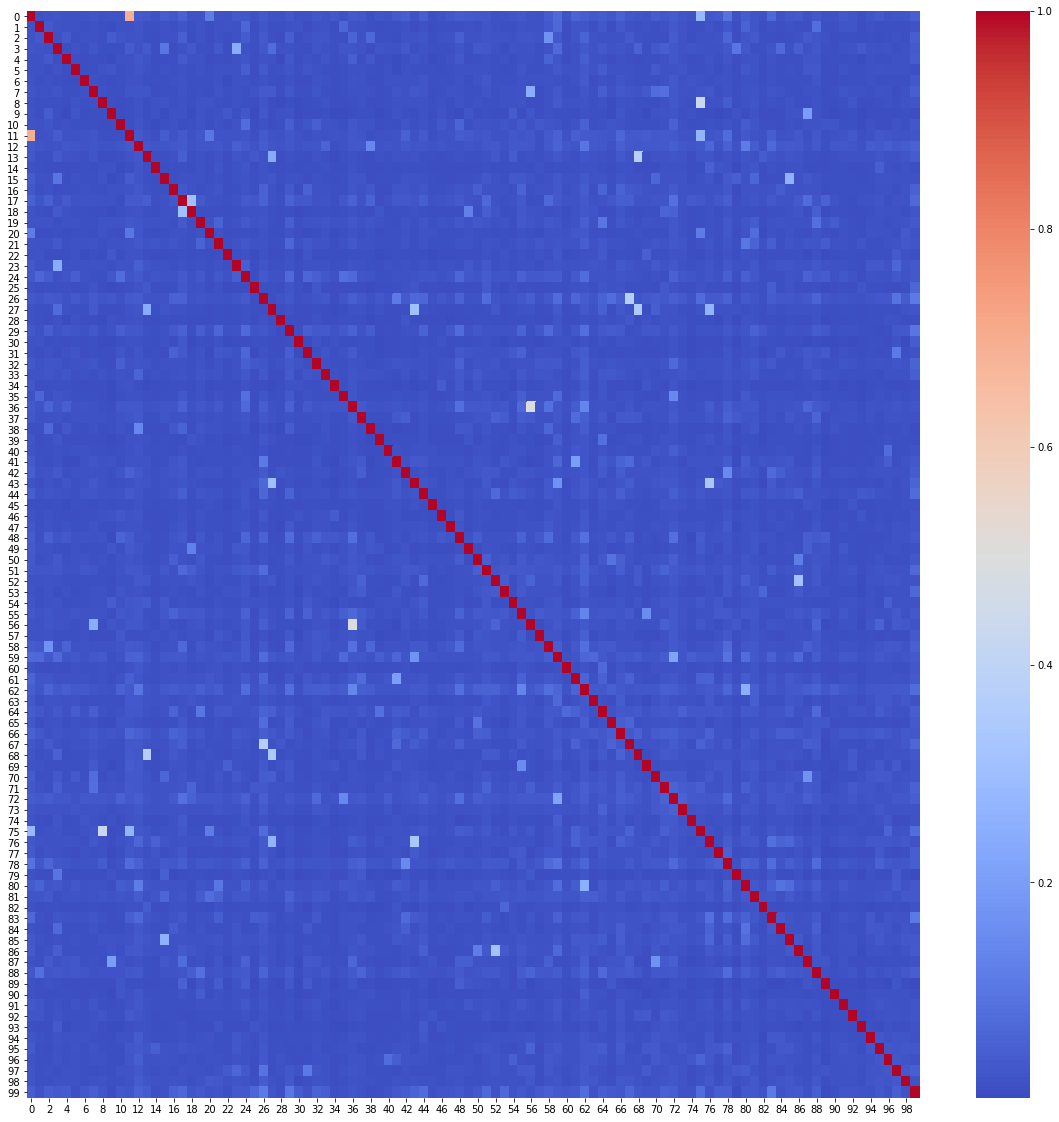

In [261]:
plt.figure(figsize = (20,20))
sns.heatmap(cos_matrix,cmap='coolwarm',linecolor='white')

In [268]:
print('The only two similar titles are '+titles[0]+' and '+titles[11]+' ,which makes sense.')

The only two similar titles are The Godfather and The Godfather: Part II ,which makes sense.


# Part 4. K-Means Clustering

In [270]:
# k-means clustering
from sklearn.cluster import KMeans

# number of clusters
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## Analyzing K-Means Results

In [271]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [272]:
frame.head(10)

,rank,title,cluster
3,0,The Godfather,3
1,1,The Shawshank Redemption,1
0,2,Schindler's List,0
4,3,Raging Bull,4
1,4,Casablanca,1
0,5,One Flew Over the Cuckoo's Nest,0
1,6,Gone with the Wind,1
1,7,Citizen Kane,1
3,8,The Wizard of Oz,3
0,9,Titanic,0


In [273]:
print ("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
1,56
0,17
3,14
2,8
4,5


In [274]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ",", end='')
    print ()
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print (", ".join(cluster_movies))
    print ()

<Document clustering result by K-means>
Cluster 0 words:rose,german,charlie,dunbar,captain,patton,
Cluster 0 titles (17 movies): 
Schindler's List, One Flew Over the Cuckoo's Nest, Titanic, The Sound of Music, The Bridge on the River Kwai, Apocalypse Now, Gandhi, Saving Private Ryan, My Fair Lady, Patton, Jaws, Dances with Wolves, The Pianist, Rain Man, Out of Africa, The African Queen, Mutiny on the Bounty

Cluster 1 words:joe,jerry,paul,kane,tom,rocky,
Cluster 1 titles (56 movies): 
The Shawshank Redemption, Casablanca, Gone with the Wind, Citizen Kane, Lawrence of Arabia, Psycho, Sunset Blvd., Vertigo, Forrest Gump, Star Wars, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Some Like It Hot, 12 Angry Men, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Amadeus, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Raiders of the Lost Ark, Rocky, A Streetcar Named Desire, To Kill a Mockingbird, An American in Paris, Ben-Hur

## Plot K-Means Results

In [275]:
# use pca to reduce dimensions to 2d for visibility, just want to see if there 2d can give us some insights
# this is not an appropriate method, just a guess.
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

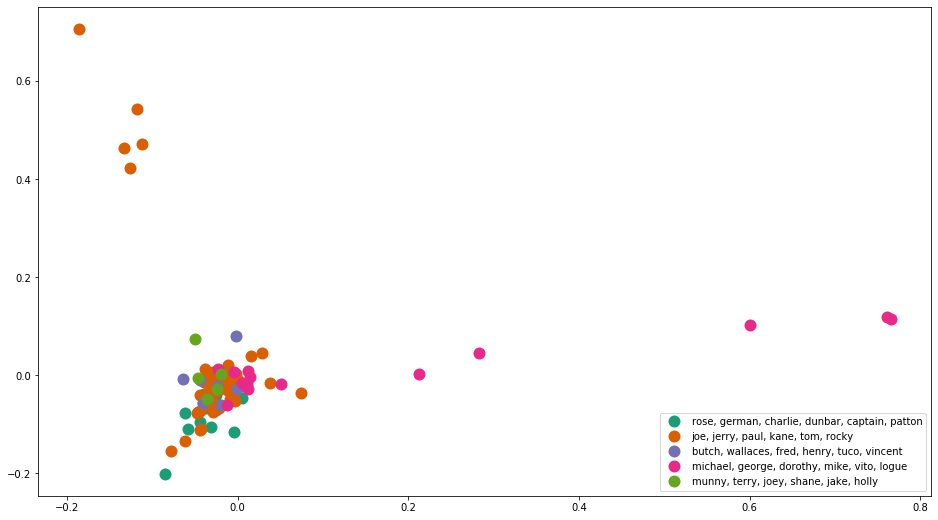

In [276]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

# part 5. Latent Dirichlet Allocation(tf-idf)

In [277]:
# LDA requires integer values, keep first 3 digits
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [278]:
from sklearn.decomposition import LatentDirichletAllocation as lda
lda = LatentDirichletAllocation(n_components=7)

In [238]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [239]:
# topics and words matrixw
topic_word = lda.components_
print(topic_word.shape)

(7, 2000)


In [240]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [241]:
# documents and topics matri
doc_topic = lda.transform(tfidf_matrix_lda)
print (doc_topic.shape)

(100, 7)


In [242]:
# print out the clusters and topics and titles of the movies
topic_doc_dict = {}
print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print (', '.join(topic_doc_dict[i]))
    print ()

<Document clustering result by LDA>
Cluster 2 words: michael, dorothy, joe, terry, beale, schindler
Cluster 2 titles (17 movies): 
The Godfather, Schindler's List, The Wizard of Oz, The Godfather: Part II, Sunset Blvd., On the Waterfront, The Silence of the Lambs, Singin' in the Rain, Apocalypse Now, The Exorcist, The Deer Hunter, The French Connection, City Lights, Midnight Cowboy, Tootsie, Network, American Graffiti

Cluster 3 words: andy, munny, thorwald, scotty, luke, miller
Cluster 3 titles (16 movies): 
The Shawshank Redemption, Psycho, Vertigo, Star Wars, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, The Lord of the Rings: The Return of the King, Saving Private Ryan, Unforgiven, To Kill a Mockingbird, My Fair Lady, Doctor Zhivago, Good Will Hunting, Pulp Fiction, Stagecoach, Rear Window, Yankee Doodle Dandy

Cluster 1 words: rose, karen, charlie, jim, kane, logue
Cluster 1 titles (14 movies): 
Raging Bull, Citizen Kane, Titanic, The Sound of Music, 2001: 

# part 6. Latent Dirichlet Allocation(bag of words)

In [280]:
# doc dictionary with title as key,tokenized words as values
doc_dic = {titles[i]:tokenization_and_stemming(synopses[i]) for i in range(len(synopses))}

In [281]:
# get a list of all words in all documents
n_nonzero = 0
vocab=[]
for docterms in doc_dic.values():
    unique_terms = set(docterms)    # all unique terms of this doc
    vocab += unique_terms           # set union: add unique terms of this doc
    n_nonzero += len(unique_terms)  # add count of unique terms in this doc

# make a list of document names
# the order will be the same as in the dict
docnames = list(doc_dic.keys())

In [282]:
docnames = np.array(docnames)
vocab = np.array(list(vocab)) 

In [283]:
vocab_sorter = np.argsort(vocab) 

In [284]:
# there are 100 titles and 56959 unique words in totall.we looking at a matrix as this size
ndocs = len(docnames)
nvocab = len(vocab)

print(ndocs,nvocab)

100 56959


In [285]:
# making some empty space for the matrix. intc is 32, saving a lot of memory
data = np.empty(n_nonzero, dtype=np.intc)     # all non-zero term frequencies at data[k]
rows = np.empty(n_nonzero, dtype=np.intc)     # row index for kth data item (kth term freq.)
cols = np.empty(n_nonzero, dtype=np.intc)     # column index for kth data 

In [287]:
ind = 0     # current index in the sparse matrix data
# go through all documents with their terms
for docname, terms in doc_dic.items():
    # find indices into  such that, if the corresponding elements in  were
    # inserted before the indices, the order of  would be preserved
    # -> array of indices of  in 
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ind_end = ind + n_vals  #  to  is the slice that we will fill with data

    data[ind:ind_end] = counts                  # save the counts (term frequencies)
    cols[ind:ind_end] = uniq_indices            # save the column index: index in 
    doc_idx = np.where(docnames == docname)     # get the document index for the document name
    rows[ind:ind_end] = np.repeat(doc_idx, n_vals)  # save it as repeated value

    ind = ind_end  # resume with next document -> add data to the end

In [288]:
from scipy.sparse import coo_matrix
dtm = coo_matrix((data, (rows, cols)), shape=(ndocs, nvocab), dtype=np.intc)
dtm_df = pd.DataFrame(data = dtm.toarray(),columns = vocab,index = docnames )

In [289]:
from gensim import matutils,models
import scipy.sparse

In [298]:
# gensim requires term-doc matrix 
tdm = dtm_df.transpose()
tdm.head()

,The Godfather,The Shawshank Redemption,Schindler's List,Raging Bull,Casablanca,One Flew Over the Cuckoo's Nest,Gone with the Wind,Citizen Kane,The Wizard of Oz,Titanic,...,The Maltese Falcon,A Clockwork Orange,Taxi Driver,Wuthering Heights,Double Indemnity,Rebel Without a Cause,Rear Window,The Third Man,North by Northwest,Yankee Doodle Dandy
riddl,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
na,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
burial,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advantag,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
proper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
# put tdm into a new gensim format
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [300]:
# index of vocab is required
id2word = dict((x,vocab[x]) for x in range(len(vocab)))

In [301]:
#topic in each title. we take top 11 because the first are always "\'s" and "the" which is meaningl ess

lda = models.LdaModel(corpus=corpus,id2word=id2word,num_topics = 6,passes=12)
lda.print_topics()

[(0,
  '0.017*"\'s" + 0.007*"the" + 0.005*"scarlett" + 0.004*"he" + 0.004*"luke" + 0.003*"take" + 0.003*"tell" + 0.003*"wallac" + 0.003*"shark" + 0.003*"rhett"'),
 (1,
  '0.018*"\'s" + 0.005*"he" + 0.004*"the" + 0.004*"michael" + 0.004*"tell" + 0.004*"famili" + 0.003*"kill" + 0.003*"take" + 0.003*"leav" + 0.003*"juror"'),
 (2,
  '0.014*"\'s" + 0.007*"the" + 0.003*"maximus" + 0.003*"maria" + 0.003*"kill" + 0.003*"he" + 0.003*"toni" + 0.003*"leav" + 0.003*"arriv" + 0.003*"find"'),
 (3,
  '0.014*"\'s" + 0.008*"rocki" + 0.006*"the" + 0.004*"tell" + 0.004*"miller" + 0.004*"he" + 0.003*"joe" + 0.003*"paul" + 0.003*"john" + 0.003*"one"'),
 (4,
  '0.017*"\'s" + 0.007*"the" + 0.007*"he" + 0.004*"georg" + 0.004*"tell" + 0.003*"get" + 0.003*"man" + 0.003*"find" + 0.003*"tri" + 0.003*"kill"'),
 (5,
  '0.013*"\'s" + 0.007*"dorothi" + 0.005*"spade" + 0.004*"the" + 0.004*"will" + 0.004*"michael" + 0.004*"tell" + 0.004*"jean" + 0.004*"barbara" + 0.004*"kane"')]

In [302]:
corpus_transformed = lda[corpus]
print (corpus_transformed)

In [303]:
result = []
for i in range(len(corpus_transformed)):
    result.append(corpus_transformed[i][0][0])

In [304]:
result_df = pd.DataFrame(data = result,columns = ["topic"],index = titles ).reset_index()
result_df.head()

,index,topic
0,The Godfather,1
1,The Shawshank Redemption,4
2,Schindler's List,2
3,Raging Bull,3
4,Casablanca,4


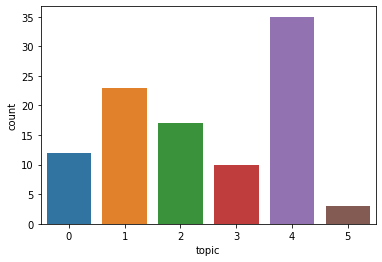

In [305]:
import seaborn as sns
%matplotlib inline
sns.countplot(x='topic',data=result_df)

# take-away:

1. All the results(knn,tf-idf lda or bag-of-word lda) only provide us several sets of words,they are not necessarily topics
2. Names often become the top frequent words of a topic. Names are meaningless themselves, to better the meaning of a topic, we might want to filter out names and kepp adjectives,nouns and verbs in our data.
3. If a the output doesn't form a meaningful topic, keep tuning model parameters until find a meaningful output.
4. Are these models good clustering or classification? Need metrics to evaluate model perfomance. 